### ATM 651 Introduction of Atmospheric Dynamics: Project option
University of Miami, RSMAS. 2019 Fall 
### 2D Shallow water equation model 
This notebook is adapted from [Dr. Paul Connally's webpage.](https://personalpages.manchester.ac.uk/staff/paul.connolly/teaching/practicals/shallow_water_equations.html)
This model integrates the [shallow water equations](https://en.wikipedia.org/wiki/Shallow_water_equations) in conservative form in a channel using the [Lax-Wendroff method](https://en.wikipedia.org/wiki/Lax%E2%80%93Wendroff_method), a numerical method for the solution of hyperbolic partial differential equations, based on [finite differences](https://en.wikipedia.org/wiki/Finite_difference_method). It is second-order accurate in both space and time.

In [2]:
import numpy as np
import sys
import os
from scipy.special import erfcinv as erfcinv
import tqdm as tqdm  # pause jupyter and pip install tqdm if necessary
import time
import scipy.io as sio
import lax_wendroff_Hsrc as lw

In [4]:
import warnings
warnings.simplefilter("ignore")

### Main code
There are options for different simulations and flexible parameters

In [5]:
# SECTION 0: Definitions (normally don't modify this section)

# Possible initial conditions of the height field
UNIFORM_WESTERLY=1;
ZONAL_JET=2;
REANALYSIS=3;
GAUSSIAN_BLOB=4;
STEP=5;
CYCLONE_IN_WESTERLY=6;
SHARP_SHEAR=7;
EQUATORIAL_EASTERLY=8;
SINUSOIDAL=9;
HEAT_SRC=10

# Possible orographies
FLAT=0;
SLOPE=1;
GAUSSIAN_MOUNTAIN=2;
EARTH_OROGRAPHY=3;
SEA_MOUNT=4;

# ------------------------------------------------------------------
# SECTION 1: Configuration
g    = 9.81;                # Acceleration due to gravity (m/s2)
f    = 1e-4;              # Coriolis parameter (s-1)
#f=0.;
beta = 1.6e-11;             # Meridional gradient of f (s-1m-1)
#beta=0.;
#beta=5e-10;

dt_mins              = 0.5;   # Timestep (minutes)
output_interval_mins = 60.;  # Time between outputs (minutes)
forecast_length_days = 4.;   # Total simulation length (days)

orography = FLAT
initial_conditions = HEAT_SRC; # Type of initial condition for height
initially_geostrophic = True;   # Can be "True" or "False"
add_random_height_noise = False; # Can be "True" or "False"

# If you change the number of gridpoints then orography=EARTH_OROGRAPHY
# or initial_conditions=REANALYSIS won't work
nx=254; # Number of zonal gridpoints
ny=50;  # Number of meridional gridpoints

dx=100.0e3; # Zonal grid spacing (m)
dy=dx;      # Meridional grid spacing

# Specify the range of heights to plot in metres
plot_height_range = np.array([9500., 10500.]);

# ------------------------------------------------------------------
# SECTION 2: Act on the configuration information
dt = dt_mins*60.0; # Timestep (s)
output_interval = output_interval_mins*60.0; # Time between outputs (s)
forecast_length = forecast_length_days*24.0*3600.0; # Forecast length (s)
nt = int(np.fix(forecast_length/dt)+1); # Number of timesteps
timesteps_between_outputs = np.fix(output_interval/dt);
noutput = int(np.ceil(nt/timesteps_between_outputs)); # Number of output frames

x=np.mgrid[0:nx]*dx; # Zonal distance coordinate (m)
y=np.mgrid[0:ny]*dy; # Meridional distance coordinate (m)
[Y,X] = np.meshgrid(y,x); # Create matrices of the coordinate variables



# Create the orography field "H"
if orography == FLAT:
    H = np.zeros((nx, ny));
elif orography == SLOPE:
    H = 9000.*2.*np.abs((np.mean(x)-X)/np.max(x));
elif orography == GAUSSIAN_MOUNTAIN:
    std_mountain_x = 5.*dx; # Std. dev. of mountain in x direction (m)
    std_mountain_y = 5.*dy; # Std. dev. of mountain in y direction (m)
    H = 4000.*np.exp(-0.5*((X-np.mean(x))/std_mountain_x)**2. \
                  -0.5*((Y-np.mean(y))/std_mountain_y)**2.);
elif orography == SEA_MOUNT:
    std_mountain = 40.0*dy; # Standard deviation of mountain (m)
    H = 9250.*np.exp(-((X-np.mean(x))**2.+(Y-0.5*np.mean(y))**2.)/(2.*std_mountain**2.));
elif orography == EARTH_OROGRAPHY:
    mat_contents = sio.loadmat('digital_elevation_map.mat')
    H = mat_contents['elevation'];
    # Enforce periodic boundary conditions in x
    H[[0, -1],:]=H[[-2, 1],:];
else:
    print('Don''t know what to do with orography=' + np.num2str(orography)); 
    sys.exit()



# Create the initial height field 
if initial_conditions == UNIFORM_WESTERLY:
    mean_wind_speed = 20.; # m/s
    height = 10000.-(mean_wind_speed*f/g)*(Y-np.mean(y)); 
elif initial_conditions == SINUSOIDAL:
    height = 10000.-350.*np.cos(Y/np.max(y)*4.*np.pi);
elif initial_conditions == EQUATORIAL_EASTERLY:
    height = 10000. - 50.*np.cos((Y-np.mean(y))*4.*np.pi/np.max(y));
elif initial_conditions == ZONAL_JET:
    height = 10000. - np.tanh(20.0*((Y-np.mean(y))/np.max(y)))*400.;
elif initial_conditions == REANALYSIS:
    mat_contents = sio.loadmat('reanalysis.mat')
    pressure = mat_contents['pressure'];
    height = 0.99*pressure/g;
elif initial_conditions == GAUSSIAN_BLOB:
    std_blob = 8.0*dy; # Standard deviation of blob (m)
    height = 9750. + 1000.*np.exp(-((X-0.25*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2.* \
                                                     std_blob**2.));
elif initial_conditions == STEP:
    height = 9750.*np.ones((nx, ny));
    height[where((X<np.max(x)/5.) & (Y>np.max(y)/10.) & (Y<np.max(y)*0.9))] = 10500.;
elif initial_conditions == CYCLONE_IN_WESTERLY:
    mean_wind_speed = 20.; # m/s
    std_blob = 7.0*dy; # Standard deviation of blob (m)
    height = 10000.-(mean_wind_speed*f/g)*(Y-np.mean(y)) \
        - 500.*np.exp(-((X-0.5*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2.*std_blob**2.));
    max_wind_speed = 20.; # m/s
    height = 10250.-(max_wind_speed*f/g)*(Y-np.mean(y))**2./np.max(y) \
        - 1000.*np.exp(-(0.25*(X-1.5*np.mean(x))**2.+(Y-0.5*np.mean(y))**2.)/(2.*std_blob**2.));
elif initial_conditions == SHARP_SHEAR:
    mean_wind_speed = 50.; # m/s
    height = (mean_wind_speed*f/g)*np.abs(Y-np.mean(y));
    height = 10000.+height-np.mean(height[:]);
elif initial_conditions == HEAT_SRC:
    mean_wind_speed = 20.; # m/s
    height = 10000.*np.ones((nx, ny))
else:
    print("Don't know what to do with initial_conditions=%f" % initial_conditions); 
    sys.exit()

In [8]:
# Coriolis parameter as a matrix of values varying in y only
F = f+beta*(Y-np.mean(y));

# Initialize the wind to rest
u=np.zeros((nx, ny));
v=np.zeros((nx, ny));

# We may need to add small-amplitude random noise in order to initialize 
# instability
if add_random_height_noise:
    r,c=np.shape(height)
    height = height + 1.0*np.random.randn(r,c)*(dx/1.0e5)*(np.abs(F)/1e-4);


if initially_geostrophic:

    # Centred spatial differences to compute geostrophic wind
    u[:,1:-1] = -(0.5*g/(F[:,1:-1]*dx)) \
        * (height[:,2:]-height[:,0:-2]);
    v[1:-1,:] = (0.5*g/(F[1:-1,:]*dx)) \
        * (height[2:,:]-height[0:-2,:]);
    # Zonal wind is periodic so set u(1) and u(end) as dummy points that
    # replicate u(end-1) and u(2), respectively
    u[[0 ,-1],:] = u[[1 ,-2],:];
    # Meridional wind must be zero at the north and south edges of the
    # channel 
    v[:,[0, -1]] = 0.;

    # Don't allow the initial wind speed to exceed 200 m/s anywhere
    max_wind = 200.;
    u[np.where(u>max_wind)] = max_wind;
    u[np.where(u<-max_wind)] = -max_wind;
    v[np.where(v>max_wind)] = max_wind;
    v[np.where(v<-max_wind)] = -max_wind;


# Define h as the depth of the fluid (whereas "height" is the height of
# the upper surface)
h = height - H;

# Initialize the 3D arrays where the output data will be stored
u_save = np.zeros((nx, ny, noutput));
v_save = np.zeros((nx, ny, noutput));
h_save = np.zeros((nx, ny, noutput));
t_save = np.zeros((noutput,1));

# Index to stored data
i_save = 0;

# external heat source adding to h equation
hsrc = H.copy()
hsrc[np.where(np.sqrt((X-np.mean(x))**2.+(Y-np.mean(y))**2.) <= 1000e3)] = 0.138 # m/mins

# ------------------------------------------------------------------
# SECTION 3: Main loop
for n in range(0,nt):
   # Every fixed number of timesteps we store the fields
    if np.mod(n,timesteps_between_outputs) == 0:
   
        max_u = np.sqrt(np.max(u[:]*u[:]+v[:]*v[:]));
      
        print("Time = %f hours (max %f); max(|u|) = %f"  
           % ((n)*dt/3600., forecast_length_days*24., max_u) )
   
        u_save[:,:,i_save] = u;
        v_save[:,:,i_save] = v;
        h_save[:,:,i_save] = h;
        t_save[i_save] = (n)*dt;
        i_save = i_save+1;
  

   # Compute the accelerations
    u_accel = F[1:-1,1:-1]*v[1:-1,1:-1] \
              - (g/(2.*dx))*(H[2:,1:-1]-H[0:-2,1:-1]);
    v_accel = -F[1:-1,1:-1]*u[1:-1,1:-1] \
              - (g/(2.*dy))*(H[1:-1,2:]-H[1:-1,0:-2]);
    h_accel = hsrc # height source (heating)

   # Call the Lax-Wendroff scheme to move forward one timestep
    (unew, vnew, h_new) = lw.lax_wendroff(dx, dy, dt, g, u, v, h, u_accel, v_accel, h_accel);

   # Update the wind and height fields, taking care to enforce 
   # boundary conditions 
    """
    u = unew([end 1:end 1],[1 1:end end]);
    v = vnew([end 1:end 1],[1 1:end end]);
    v(:,[1 end]) = 0;
    h(:,2:end-1) = h_new([end 1:end 1],:);
    """
    u[1:-1,1:-1] = unew[0:,0:];
    u[[-1,0],1:-1]  = unew[[0,-1],:]
    u[1:-1,[0,-1]]  = unew[:,[0,-1]]

    v[1:-1,1:-1] = vnew[0:,0:];
    v[[-1,0],0]  = vnew[[0,-1],0]
    v[1:-1,[0,-1]]  = vnew[:,[0,-1]]
   
    v[:,[0, -1]] = 0.;

    h[1:-1,1:-1] = h_new[0:,0:];
    h[[0,-1],1:-1]  = h_new[[-1,0],:]


print('Run completed successfully');

Time = 0.000000 hours (max 96.000000); max(|u|) = 0.000000
Time = 1.000000 hours (max 96.000000); max(|u|) = 7.229326
Time = 2.000000 hours (max 96.000000); max(|u|) = 9.128339
Time = 3.000000 hours (max 96.000000); max(|u|) = 9.843027
Time = 4.000000 hours (max 96.000000); max(|u|) = 11.199384
Time = 5.000000 hours (max 96.000000); max(|u|) = 12.808451
Time = 6.000000 hours (max 96.000000); max(|u|) = 14.474019
Time = 7.000000 hours (max 96.000000); max(|u|) = 16.003143
Time = 8.000000 hours (max 96.000000); max(|u|) = 17.577276
Time = 9.000000 hours (max 96.000000); max(|u|) = 19.184760
Time = 10.000000 hours (max 96.000000); max(|u|) = 21.087192
Time = 11.000000 hours (max 96.000000); max(|u|) = 22.907067
Time = 12.000000 hours (max 96.000000); max(|u|) = 24.618221
Time = 13.000000 hours (max 96.000000); max(|u|) = 26.199505
Time = 14.000000 hours (max 96.000000); max(|u|) = 27.636008
Time = 15.000000 hours (max 96.000000); max(|u|) = 28.922523
Time = 16.000000 hours (max 96.000000)

### plot and save figures

Maximum orography height = 0.000000 m


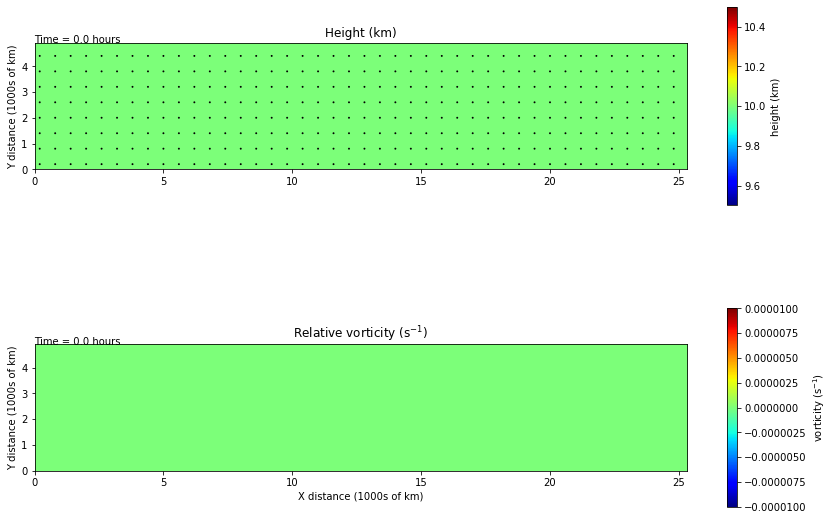

In [20]:
import matplotlib.pyplot as plt
from matplotlib import rc

# create a folder in the current directory
os.system('rm -r fig');os.system('mkdir fig')

#f,(ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
f=plt.figure(figsize=(12,10))
ax1=plt.subplot(2,1,1)
ax2=plt.subplot(2,1,2)

#ax1.autoscale(enable=True, axis='y', tight=True)

# Axis units are thousands of kilometers (x and y are in metres)
x_1000km = x * 1.e-6
y_1000km = y * 1.e-6

# Set colormap to have 64 entries
ncol=64;

# Interval between arrows in the velocity vector plot
interval = 6;

# Set this to "True" to save each frame as a png file
plot_frames = False;

# Decide whether to show height in metres or km
if np.mean(plot_height_range) > 1000:
    height_scale = 0.001;
    height_title = 'Height (km)';
else:
    height_scale = 1;
    height_title = 'Height (m)';


print('Maximum orography height = %f m' % np.max(H[:]));
u = np.squeeze(u_save[:,:,0]);
vorticity = np.zeros(np.shape(u));

# Loop through the frames of the animation
for it in range(0,noutput):

    # Extract the height and velocity components for this frame
    h = np.squeeze(h_save[:,:,it]);
    u = np.squeeze(u_save[:,:,it]);
    v = np.squeeze(v_save[:,:,it]);

    # Compute the vorticity
    vorticity[1:-1,1:-1] = (1./dy)*(u[1:-1,0:-2]-u[1:-1,2:]) \
      + (1./dx)*(v[2:,1:-1]-v[0:-2,1:-1]);
    # First plot the height field

    if it==0:

        # Plot the height field
        im=ax1.imshow(np.transpose(h+H)*height_scale, \
         extent=[np.min(x_1000km),np.max(x_1000km),np.min(y_1000km),np.max(y_1000km)], \
         cmap='jet')
        # Set other axes properties and plot a colorbar
        cb1=plt.colorbar(im,ax=ax1,shrink=0.5)
        cb1.set_label('height (km)')
        # Contour the terrain:
        cs=ax1.contour(x_1000km,y_1000km,np.transpose(H),levels=np.arange(0,10000,1000),colors='k')

        # Plot the velocity vectors
        Q = ax1.quiver(x_1000km[2::interval],y_1000km[2::interval], \
         np.transpose(u[2::interval,2::interval]), \
         np.transpose(v[2::interval,2::interval]), scale=5e2,scale_units='xy',pivot='mid')
        ax1.set_ylabel('Y distance (1000s of km)');
        ax1.set_title(height_title);
        tx1=ax1.text(0, np.max(y_1000km), 'Time = %.1f hours' % (t_save[it]/3600.));

        # Now plot the vorticity
        im2=ax2.imshow(np.transpose(vorticity), \
         extent=[np.min(x_1000km),np.max(x_1000km),np.min(y_1000km),np.max(y_1000km)], \
         cmap='jet',vmax=1e-5,vmin=-1e-5)
        # Set other axes properties and plot a colorbar
        cb2=plt.colorbar(im2,ax=ax2,shrink=0.5)
        cb2.set_label('vorticity (s$^{-1}$)')
        ax2.set_xlabel('X distance (1000s of km)');
        ax2.set_ylabel('Y distance (1000s of km)');
        ax2.set_title('Relative vorticity (s$^{-1}$)');
        tx2=ax2.text(0, np.max(y_1000km), 'Time = %.1f hours' % (t_save[it]/3600.));
        
        plt.tight_layout()

    else:
        # top plot:
        im.set_data(np.transpose(H+h)*height_scale)
        cs.set_array(np.transpose(h))
        Q.set_UVC(np.transpose(u[2::interval,2::interval]), \
               np.transpose(v[2::interval,2::interval]))
        tx1.set_text('Time = %.1f hours' % (t_save[it]/3600.));

        # bottom plot:
        im2.set_data(np.transpose(vorticity))
        tx2.set_text('Time = %.1f hours' % (t_save[it]/3600.));

    im.set_clim((plot_height_range*height_scale));
    im2.set_clim((-1e-5,1e-5));
    ax1.axis((0., np.max(x_1000km), 0., np.max(y_1000km)));
    ax2.axis((0., np.max(x_1000km), 0., np.max(y_1000km)));
    
    # To make an animation we can save the frames as a 
    # sequence of images
    if plot_frames:
        plt.savefig('./fig/frame%03d.png' % it,format='png',dpi=200)

    plt.pause(0.1)

In [19]:
!ls ATM651_IntroAtmDynamics/Notebooks/fig

ls: ATM651_IntroAtmDynamics/Notebooks/fig: No such file or directory


In [12]:
hsrc = H.copy()
hsrc[np.where(np.sqrt((X-np.mean(x))**2.+(Y-np.mean(y))**2.) <= 1000e3)]=50/s;

NameError: name 's' is not defined

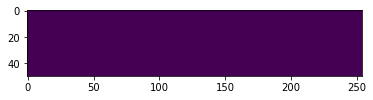

In [13]:
plt.imshow(hsrc.transpose())

In [62]:
hsrc.max()

0.0